## GAN-based attack

### Train GAN

In [1]:
start_path = "./PPF/" ## Format "./  /"

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd

# Define generator model
def build_generator(z_dim):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_dim=z_dim),
        layers.Dense(256, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(28 * 28, activation='tanh'),
        layers.Reshape((28, 28, 1))
    ])
    return model

# Define attack function
def attack_model(victim_model_path, z_dim=100, target_label=3, epochs=1000, batch_size=16):
    generator = build_generator(z_dim)
    log_data = []

    # Load victim model
    victim_model = tf.keras.models.load_model(victim_model_path, safe_mode=False)

    # Loss and optimizer
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.Adam(0.0001)
    target_label_tensor = tf.constant([target_label] * batch_size)

    print(f"Victim: {victim_model_path}: ")

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            # Sample random noise
            z = tf.random.normal([batch_size, z_dim])

            # Generate images
            generated_images = generator(z)

            # Get victim model predictions
            predictions = victim_model(generated_images)

            # Compute loss
            target_loss = loss_fn(target_label_tensor, predictions)
            reg_loss = tf.reduce_mean(tf.square(generated_images - 0.5))
            loss = target_loss + 0.1 * reg_loss

            # Log statistics
            log_data.append({
                "Epoch": epoch + 1,
                "Total Loss": loss.numpy(),
                "Target Loss": target_loss.numpy(),
                "Regularization Loss": reg_loss.numpy()
            })

        # Backpropagation
        gradients = tape.gradient(loss, generator.trainable_variables)
        optimizer.apply_gradients(zip(gradients, generator.trainable_variables))

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.numpy():.4f}")

    # Save the generator and log
    generator.save(f"{start_path}generator_inversion_attack_{victim_model_path.split('/')[-1].split('.')[0]}.keras")
    df_log = pd.DataFrame(log_data)
    df_log.to_csv(f"{start_path}attack_log_{victim_model_path.split('/')[-1].split('.')[0]}.csv", index=False)
    print(f"Attack log saved to attack_log_{victim_model_path.split('/')[-1].split('.')[0]}.csv")


# Define dim laten vector
z_dim=100
target_label=3

# Example usage for different models
attack_model(f"{start_path}victim_simple_cnn_model.keras", z_dim=z_dim, target_label=target_label)
attack_model(f"{start_path}victim_cnn_model.keras", z_dim=z_dim, target_label=target_label)

c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Victim: ./PPF/victim_simple_cnn_model.keras: 


c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend\tensorflow\nn.py:678: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch [1/1000], Loss: 3.3802
Epoch [2/1000], Loss: 2.4077
Epoch [3/1000], Loss: 1.5518
Epoch [4/1000], Loss: 0.7670
Epoch [5/1000], Loss: 0.3545
Epoch [6/1000], Loss: 0.1481
Epoch [7/1000], Loss: 0.0731
Epoch [8/1000], Loss: 0.0488
Epoch [9/1000], Loss: 0.0551
Epoch [10/1000], Loss: 0.0427
Epoch [11/1000], Loss: 0.0358
Epoch [12/1000], Loss: 0.0370
Epoch [13/1000], Loss: 0.0338
Epoch [14/1000], Loss: 0.0297
Epoch [15/1000], Loss: 0.0301
Epoch [16/1000], Loss: 0.0309
Epoch [17/1000], Loss: 0.0285
Epoch [18/1000], Loss: 0.0281
Epoch [19/1000], Loss: 0.0284
Epoch [20/1000], Loss: 0.0285
Epoch [21/1000], Loss: 0.0278
Epoch [22/1000], Loss: 0.0273
Epoch [23/1000], Loss: 0.0281
Epoch [24/1000], Loss: 0.0276
Epoch [25/1000], Loss: 0.0278
Epoch [26/1000], Loss: 0.0272
Epoch [27/1000], Loss: 0.0276
Epoch [28/1000], Loss: 0.0274
Epoch [29/1000], Loss: 0.0272
Epoch [30/1000], Loss: 0.0279
Epoch [31/1000], Loss: 0.0274
Epoch [32/1000], Loss: 0.0275
Epoch [33/1000], Loss: 0.0269
Epoch [34/1000], Lo

In [3]:
# Convert log data to DataFrame
df = pd.read_csv(f"{start_path}attack_log_victim_simple_cnn_model.csv")
df

,Epoch,Total Loss,Target Loss,Regularization Loss
0,1,3.380230,3.352532,0.276984
1,2,2.407707,2.380141,0.275662
2,3,1.551780,1.524598,0.271826
3,4,0.766984,0.739586,0.273986
4,5,0.354539,0.327436,0.271031
...,...,...,...,...
995,996,0.001488,0.000043,0.014449
996,997,0.001250,0.000030,0.012203
997,998,0.001287,0.000043,0.012433
998,999,0.001393,0.000053,0.013400


In [4]:
df = pd.read_csv(f"{start_path}attack_log_victim_cnn_model.csv")
df

,Epoch,Total Loss,Target Loss,Regularization Loss
0,1,2.480530,2.452574,0.279561
1,2,2.102749,2.074396,0.283527
2,3,1.625001,1.596687,0.283145
3,4,1.527722,1.499871,0.278508
4,5,1.191340,1.162988,0.283513
...,...,...,...,...
995,996,0.002546,0.000110,0.024354
996,997,0.002382,0.000076,0.023056
997,998,0.002516,0.000102,0.024136
998,999,0.002421,0.000082,0.023393


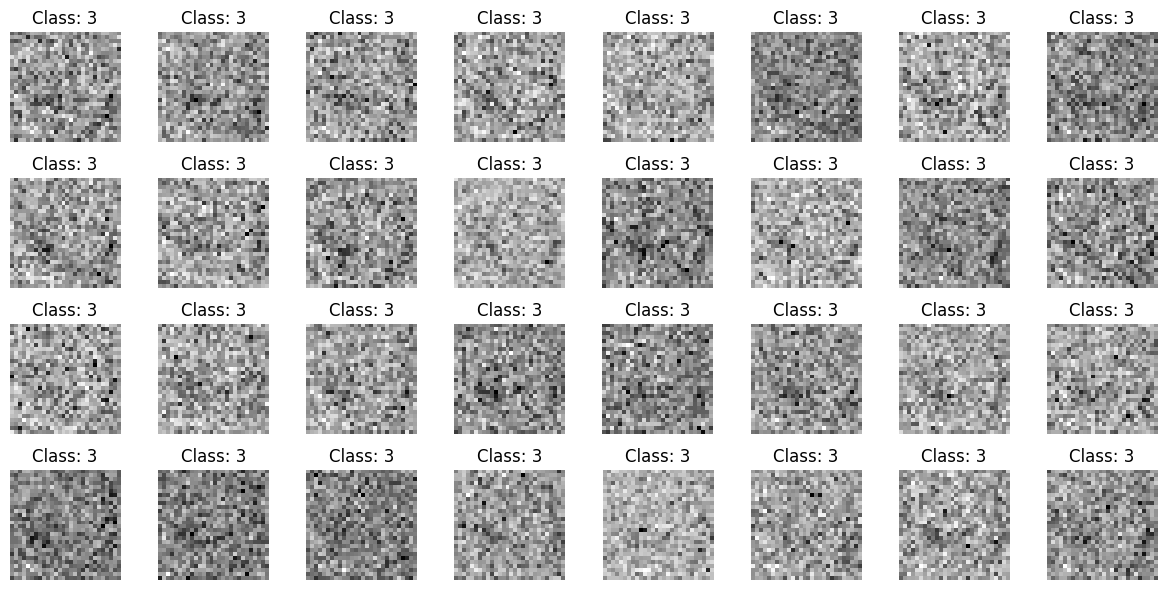

In [5]:
import matplotlib.pyplot as plt

generator_model = tf.keras.models.load_model(f"{start_path}generator_inversion_attack_victim_simple_cnn_model.keras")

# Generate and visualize reconstructed images
z = tf.random.normal([32, z_dim])
generated_images = generator_model(z).numpy()

# Plot generated images
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(generated_images[i, :, :, 0], cmap='gray')
    ax.set_title(f"Class: {target_label}")
    ax.axis('off')
plt.tight_layout()
plt.show()

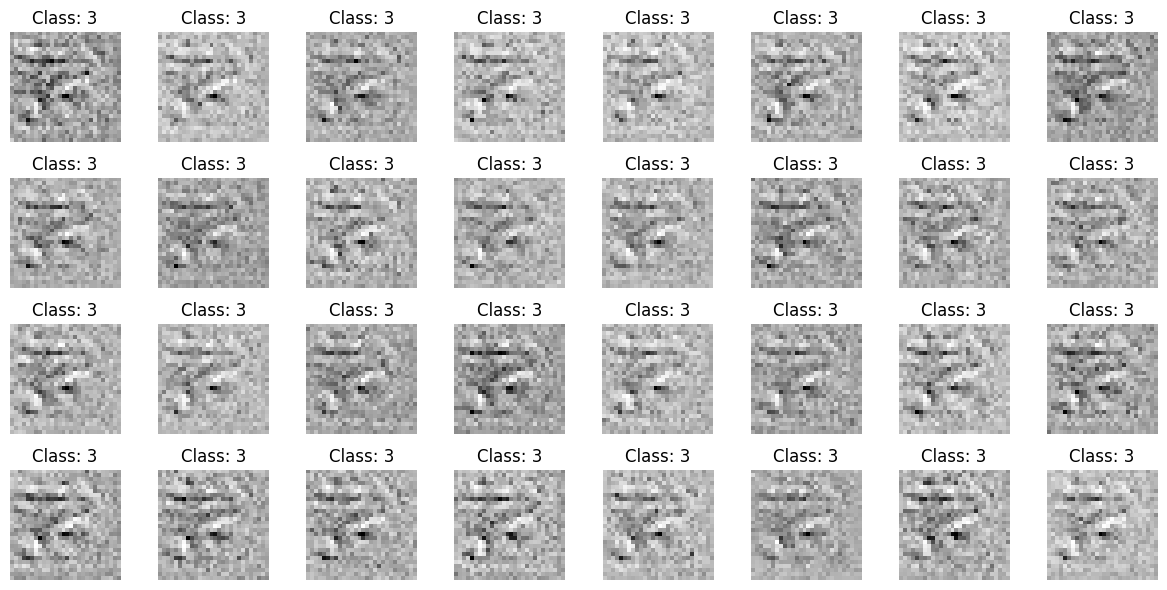

In [6]:
import matplotlib.pyplot as plt

generator_model = tf.keras.models.load_model(f"{start_path}generator_inversion_attack_victim_cnn_model.keras")

# Generate and visualize reconstructed images
z = tf.random.normal([32, z_dim])
generated_images = generator_model(z).numpy()

# Plot generated images
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(generated_images[i, :, :, 0], cmap='gray')
    ax.set_title(f"Class: {target_label}")
    ax.axis('off')
plt.tight_layout()
plt.show()